# Custom Training of Fasion MNIST Dataset
In this tutorial we will build a custom training loop including a validation loop so as to train a model on the Fashion MNIST dataset.

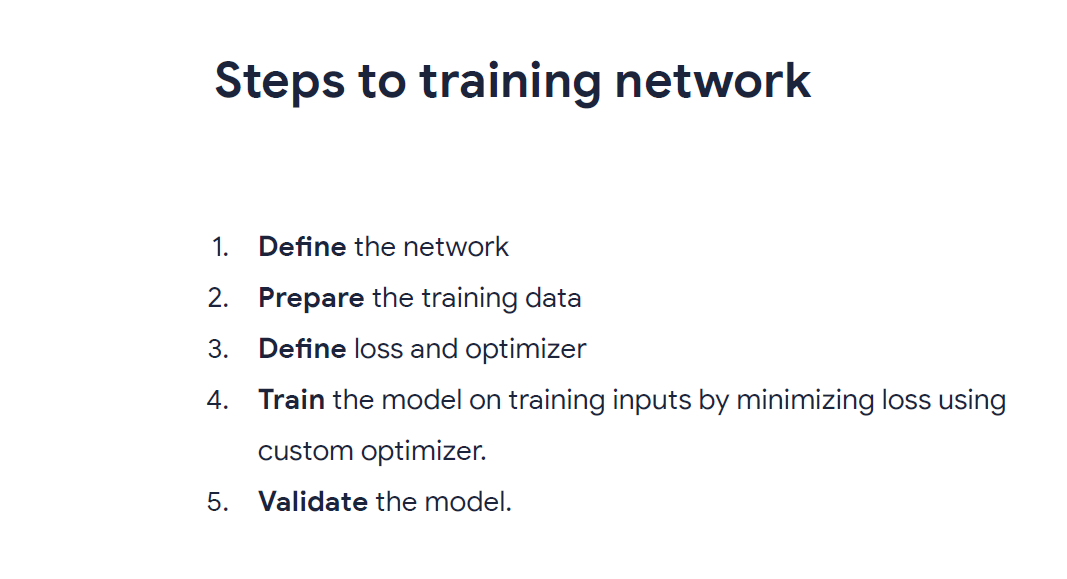

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

## Load and Preprocess Dataset
You will load the Fashion MNIST dataset using Tensorflow Datasets. This dataset has 28 x 28 grayscale images of articles of clothing belonging to 10 clases.

Here you are going to use the training and testing splits of the data. Testing split will be used for validation.

In [ ]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True)
test_data = tfds.load("fashion_mnist", split = "test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incomplete2XDI1N/fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incomplete2XDI1N/fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
class_names  = info.features["label"].names
num_classes = info.features["label"].num_classes

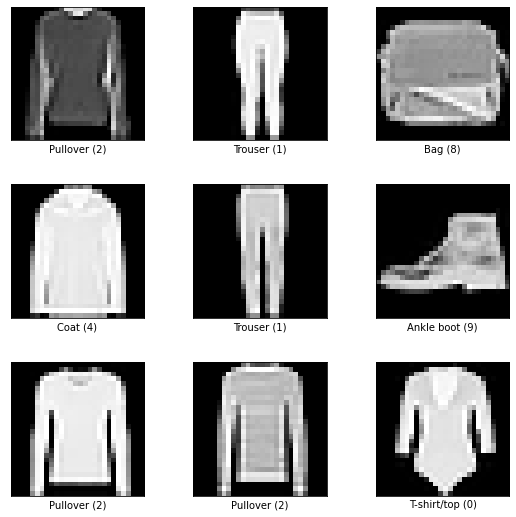

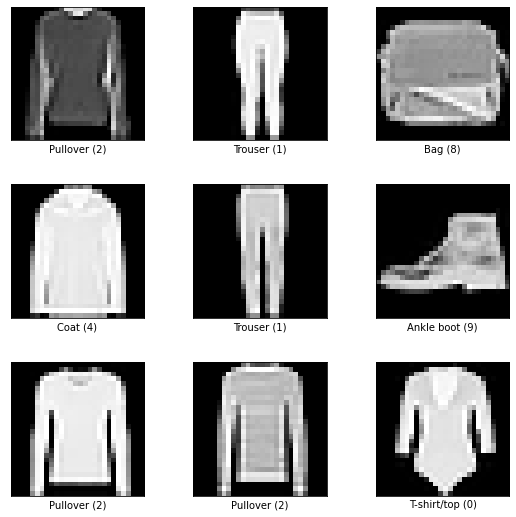

In [ ]:
tfds.visualization.show_examples(train_data, info)

In [ ]:
def format_image(data):        
    image = data["image"]
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [ ]:
batch_size = 64
train_data = train_data.map(format_image).shuffle(buffer_size=1024).batch(batch_size)
test_data = test_data.map(format_image).batch(batch_size=batch_size)

## Define the Model

In [ ]:
input_shape = (28, 28, 1)
input = tf.keras.Input(shape=input_shape)
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(input)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs=input,outputs=preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0     

## Define Optimizer and Loss Function

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

## Define Metrics
23 will also define metrics so that our training loop can update and display them. Here you are using `SparseCategoricalAccuracy` defined in `tf.keras.metrics` since the problem at hand is a multi class classification problem.



In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

## Building Training Loop
In this section you build your training loop consisting of training and validation sequences.

The core of training is using the model to calculate the logits on specific set of inputs and compute loss (in this case sparse categorical crossentropy) by comparing the predicted outputs to the true outputs. You then update the trainable weights using the optimizer algorithm chosen. Optimizer algorithm requires your computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

You use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.

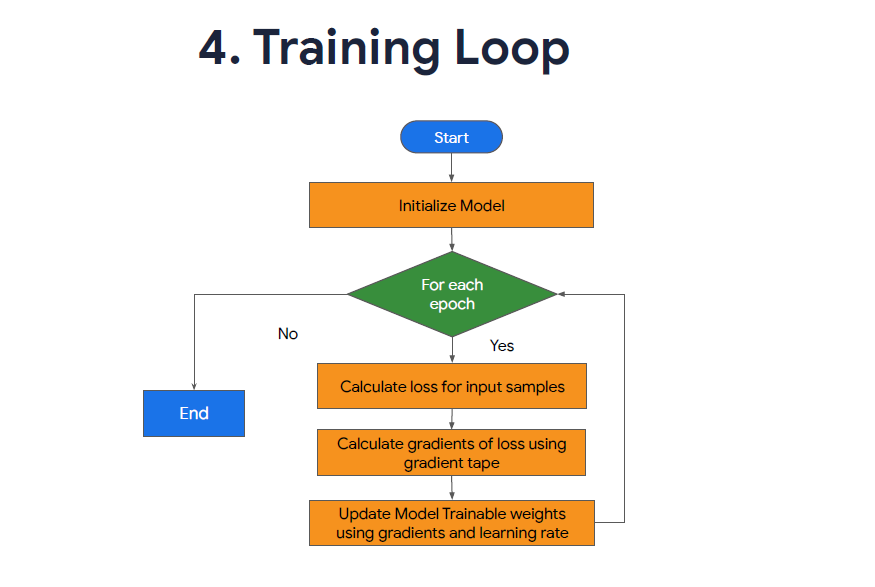

In [ ]:
def perform_validation():
  losses = []
  for x_val, y_val in test_data:
      val_logits = model(x_val)
      val_loss = loss_fn(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

In [ ]:
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    losses = []
    pbar = tqdm(total=len(list(enumerate(train_data))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    for step, (x_batch_train, y_batch_train) in enumerate(train_data):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_fn(y_true=y_batch_train, y_pred=logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        losses.append(loss_value)
        
        train_acc_metric(y_batch_train, logits)
        pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
        pbar.update()
    train_acc = train_acc_metric.result()
    losses_val = perform_validation()
    val_acc = val_acc_metric.result()

    losses_train_mean = np.mean(losses)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))

    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0


Training loss for step 937: 0.4365: 100%|██████████| 938/938 


 Epoch 0: Train loss: 0.4797  Validation Loss: 0.3986, Train Accuracy: 0.8078, Validation Accuracy 0.8600
Start of epoch 1


Training loss for step 937: 0.2557: 100%|█████████▉| 937/938 


 Epoch 1: Train loss: 0.3566  Validation Loss: 0.3492, Train Accuracy: 0.8732, Validation Accuracy 0.8765
Start of epoch 2


Training loss for step 937: 0.2557: 100%|██████████| 938/938 
Training loss for step 937: 0.1686: 100%|██████████| 938/938 


 Epoch 2: Train loss: 0.3151  Validation Loss: 0.3098, Train Accuracy: 0.8874, Validation Accuracy 0.8921
Start of epoch 3


Training loss for step 937: 0.1686: 100%|██████████| 938/938 
Training loss for step 937: 0.3791: 100%|█████████▉| 937/938 


 Epoch 3: Train loss: 0.2898  Validation Loss: 0.2990, Train Accuracy: 0.8958, Validation Accuracy 0.8953
Start of epoch 4


Training loss for step 937: 0.3791: 100%|██████████| 938/938 
Training loss for step 937: 0.3525: 100%|█████████▉| 937/938 


 Epoch 4: Train loss: 0.2692  Validation Loss: 0.2967, Train Accuracy: 0.9029, Validation Accuracy 0.8946
Start of epoch 5


Training loss for step 937: 0.3525: 100%|██████████| 938/938 
Training loss for step 937: 0.2688: 100%|█████████▉| 937/938 


 Epoch 5: Train loss: 0.2514  Validation Loss: 0.2904, Train Accuracy: 0.9099, Validation Accuracy 0.8964
Start of epoch 6


Training loss for step 937: 0.2688: 100%|██████████| 938/938 
Training loss for step 937: 0.2106: 100%|█████████▉| 937/938 


 Epoch 6: Train loss: 0.2362  Validation Loss: 0.2777, Train Accuracy: 0.9157, Validation Accuracy 0.9004
Start of epoch 7


Training loss for step 937: 0.2106: 100%|██████████| 938/938 
Training loss for step 937: 0.2644: 100%|██████████| 938/938 


 Epoch 7: Train loss: 0.2228  Validation Loss: 0.2745, Train Accuracy: 0.9193, Validation Accuracy 0.9013
Start of epoch 8


Training loss for step 937: 0.2644: 100%|██████████| 938/938 
Training loss for step 937: 0.1126: 100%|█████████▉| 937/938 


 Epoch 8: Train loss: 0.2113  Validation Loss: 0.2796, Train Accuracy: 0.9233, Validation Accuracy 0.8997
Start of epoch 9


Training loss for step 937: 0.1126: 100%|██████████| 938/938 
Training loss for step 937: 0.0902: 100%|█████████▉| 937/938 


 Epoch 9: Train loss: 0.2003  Validation Loss: 0.2704, Train Accuracy: 0.9279, Validation Accuracy 0.9036


## Plots for Evaluation
We plot the progress of loss as training proceeds over number of epochs.



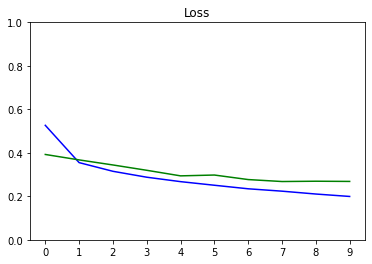

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

This function displays a row of images with their predictions and true labels.



In [ ]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

You make predictions on the test dataset and plot the images with their true and predicted values.



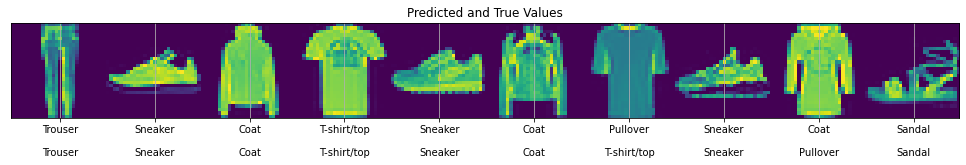

In [ ]:
test_inputs = test_data.take(1)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)